In [101]:
import sys
sys.path.append('..') 
import os
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.basics.data_org import *
from utils.photometry.preprocessing import * 
from utils.ephys.neuron_utils import isi_violations
import pickle
# %matplotlib inline
# %matplotlib widget

In [102]:
# FP data
session = 'm754896d20250102'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
signal, params = get_FP_data(session)

Loaded m754896d20250102_combined.pkl and m754896d20250102_combined_params.pkl


In [103]:
# ephys data
session = 'mZS059d20210327'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
ephys_file = os.path.join(session_dir['sortedFolder'], f"{session}_opto_units.pkl")
with open(ephys_file, 'rb') as f:
    ephys_data = pickle.load(f)

In [5]:
session_df

,trialType,trialEnd,CSon,rewardL,rewardR,respondTime,rewardTime,rewardProbL,rewardProbR,hmm
0,CSplus,192854.0,180729.0,0.0,NaN,180983.0,181284.0,10.0,90.0,90.0
1,CSplus,205883.0,192854.0,0.0,NaN,193062.0,193363.0,10.0,90.0,90.0
2,CSplus,213927.0,205883.0,0.0,NaN,206137.0,206437.0,10.0,90.0,90.0
3,CSplus,226475.0,213927.0,0.0,NaN,214166.0,214467.0,10.0,90.0,90.0
4,CSplus,230647.0,226475.0,0.0,NaN,226723.0,227024.0,10.0,90.0,90.0
...,...,...,...,...,...,...,...,...,...,...
437,CSplus,3506372.0,3500994.0,1.0,NaN,3501245.0,3501546.0,50.0,50.0,50.0
438,CSplus,3513469.0,3506372.0,0.0,NaN,3506617.0,3506918.0,50.0,50.0,50.0
439,CSplus,3517584.0,3513469.0,NaN,NaN,NaN,NaN,10.0,50.0,50.0
440,CSplus,3533093.0,3517584.0,NaN,NaN,NaN,NaN,10.0,50.0,50.0


In [46]:
import sys
sys.path.append('..') 
import os
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.basics.data_org import *
from utils.photometry.preprocessing import * 
from pynwb import NWBFile, TimeSeries
from datetime import datetime
from hdmf_zarr import NWBZarrIO
from datetime import datetime
import pytz

def isi_violations(spike_train, total_duration_s, isi_threshold_s=0.0015, min_isi_s=0):
    """
    Calculate Inter-Spike Interval (ISI) violations.

    See compute_isi_violations for additional documentation

    Parameters
    ----------
    spike_trains : list of np.ndarrays
        The spike times for each recording segment for one unit, in seconds.
    total_duration_s : float
        The total duration of the recording (in seconds).
    isi_threshold_s : float, default: 0.0015
        Threshold for classifying adjacent spikes as an ISI violation, in seconds.
        This is the biophysical refractory period.
    min_isi_s : float, default: 0
        Minimum possible inter-spike interval, in seconds.
        This is the artificial refractory period enforced
        by the data acquisition system or post-processing algorithms.

    Returns
    -------
    isi_violations_ratio : float
        The isi violation ratio described in [1].
    isi_violations_rate : float
        Rate of contaminating spikes as a fraction of overall rate.
        Higher values indicate more contamination.
    isi_violation_count : int
        Number of violations.
    """

    num_violations = 0
    num_spikes = 0

    isi_violations_ratio = np.float64(np.nan)
    isi_violations_rate = np.float64(np.nan)
    isi_violations_count = np.float64(np.nan)
    isi_violations_percentile = np.float64(np.nan)

    isis = np.diff(spike_train)
    num_spikes = len(spike_train)
    num_violations = np.sum(isis < isi_threshold_s)

    violation_time = 2 * num_spikes * (isi_threshold_s - min_isi_s)

    if num_spikes > 0:
        total_rate = num_spikes / total_duration_s
        violation_rate = num_violations / violation_time
        isi_violations_ratio = violation_rate / total_rate
        isi_violations_rate = num_violations / total_duration_s
        isi_violations_count = num_violations
        isi_violations_percentile = isi_violations_count / num_spikes

    return isi_violations_ratio, isi_violations_rate, isi_violations_count, isi_violations_percentile

def append_FP_nwb(session, nwbfile):
    session_dir = parse_session_string(session)
    channel_meta_file = os.path.join(session_dir['photometryPath'], f"{session}.json")
    signal, params = get_FP_data(session)
    with open(channel_meta_file, 'r') as f:
        channel_meta = json.load(f)
    for channel in signal.keys():
        # if channel field value is array, add it directly
        if isinstance(signal[channel], np.ndarray):
            if channel == 'time_in_beh':
                channel_name = 'FIP_rising_time'
            elif channel == 'time':
                channel_name = 'FIP_rising_time_raw'
            else:
                channel_name = channel
            ts = TimeSeries(
                name=channel_name,
                unit="second",
                timestamps=signal['time_in_beh']/1000,  # convert to seconds
                data=signal[channel],
                description=channel_meta.get(channel, {}).get('description', 'No description')
            )
            nwbfile.add_acquisition(ts)
        # if channel field value is dict, add each key-value pair as a separate TimeSeries
        elif isinstance(signal[channel], dict):
            for sub_channel, data in signal[channel].items():
                fiber_name = int([fiber for fiber, region in channel_meta.items() if region == sub_channel][0])
                if isinstance(data, np.ndarray):
                    if '_' not in channel:
                        channel_name = f"{channel}_{fiber_name}"
                    else:
                        if channel.startswith('G_') or channel.startswith('Iso_'):
                            parts = channel.split('_')
                            channel_name = f"{parts[0]}_{fiber_name}_{'_'.join(parts[1:])}"
                            # print(f"channel_name: {channel_name}")

                    ts = TimeSeries(
                        name=channel_name,
                        unit="a.u.",
                        timestamps=signal['time_in_beh']/1000,  # convert to seconds
                        data=data,
                        description=channel_meta.get(channel, {}).get('description', 'No description')
                    )
                    nwbfile.add_acquisition(ts)
    return nwbfile

def append_ephys_nwb(session, nwb_file):
    # load one nsc file to get recording time:
    data_dir = parse_session_string(session)
    rec_info_file = os.path.join(data_dir['nlynxFolderSession'], 'rec_info.json')
    with open(rec_info_file, 'r') as f:
        rec_info = json.load(f)
    rec_length = (rec_info['end']-rec_info['start'])/1000000
    # load units data
    ephys_file = os.path.join(data_dir['sortedFolder'], f"{session}_opto_units.pkl")
    with open(ephys_file, 'rb') as f:
        ephys_data = pickle.load(f)
    # If the Units table doesn't exist yet, initialize it

    if nwb_file.units is None:
        nwb_file.add_unit_column(name='unit_id', description='Unit ID')

    # Define all custom columns and descriptions
    unit_columns = [
        ('opto_unit', 'Opto unit'),
        ('firing_rate', 'Firing rate in Hz'),
        ('depth', 'Depth of the unit'),
        ('y_loc', 'Y location of the unit'),

        ('peak', 'Peak of the unit'),
        ('amplitude', 'Amplitude of the unit'),
        ('peak_wf', 'Peak waveform of the unit', True),
        ('peak_wf_aligned', 'Aligned peak waveform of the unit', True),
        ('peak_wf_opt', 'Peak waveform of the opto unit', True),
        ('peak_wf_opt_aligned', 'Aligned peak waveform of the opto unit', True),
        ('wf_2d', '2D waveform of the unit', True),
        ('wf_2d_opto', '2D waveform of the opto unit', True),
        ('mat_wf_opt', 'Matlab waveform of the opto unit', True),
        ('amplitude_opt', 'Amplitude of the opto unit'),

        ('real_unit', 'Whether the unit is a real unit'),
        ('L_ratio', 'L ratio of the unit'),
        ('isi_violation_ratio', 'ISI violation ratio of the unit'),
        ('isi_v_2ms_ratio', 'ISI violation ratio for 2ms of the unit'),
        ('presence_ratio', 'Presence ratio of the unit'),
        ('amplitude_cutoff', 'Amplitude cutoff of the unit'),
        ('decoder_label', 'Decoder label of the unit'),
        ('default_qc', 'Default QC of the unit'),
        ('snr', 'Signal to noise ratio of the unit'),

        ('p_resp', 'P response of the unit', True),
        ('lat_resp', 'Latency of the response of the unit', True),
        ('bl_max_p', 'Baseline maximum p of the unit'),
        ('p_max', 'Maximum p of the unit'),
        ('p_mean', 'Mean p of the unit'),
        ('pass_count', 'Pass count of the unit'),
        ('lat_max_p', 'Latency of the maximum p of the unit'),
        ('lat_mean', 'Latency of the mean p of the unit'),
        ('euc_max_p', 'Euclidean maximum p of the unit'),
        ('corr_max_p', 'Correlation maximum p of the unit'),
        ('opto_pass', 'Opto pass of the unit'),
        ('tagged', 'Whether the unit is tagged'),
        ('tagged_loc', 'Whether the unit is tagged with location'),
        ('pulse_width', 'Pulse width of the unit'),

        ('LC_range_top', 'Top of the LC range'),
        ('LC_range_bottom', 'Bottom of the LC range'),
    ]

    # Add the columns
    for curr_field in unit_columns:
        if len(curr_field) == 2:
            name, desc = curr_field
            index = False
        elif len(curr_field) == 3:
            name, desc, index = curr_field
        
        nwb_file.units.add_column(
            name=name,
            description=desc,
            index=index
        )
    # --- Loop through each unit and add data ---

    for ind, row in ephys_data.iterrows():
        unit_id = row['unit']
        spike_times = np.squeeze(ephys_data['spike_times'][ind][0]) / 1000
        firing_rate = len(spike_times) / rec_length
        opto_unit = row['IDfile']
        opto = True if row['opto'] == 1 else False

        if row['optoWaveform'] is not None:
            waveform = row['waveform'] * rec_info['ADBitVolts'] * 1e6
            opto_waveform = row['optoWaveform'] if row['optoWaveform'] is not None else np.zeros_like(waveform)

            peak_C = np.argmax(np.max(waveform, axis=0))
            peak_sample = np.argmax(waveform[:, peak_C])
            amp = np.max(waveform[:, peak_C]) - np.min(waveform[:, peak_C])
            peak_waveform = -waveform[:, peak_C]
            peak = waveform[peak_sample, peak_C]

            peak_C_opto = np.argmax(np.max(opto_waveform, axis=0))
            peak_sample_opto = np.argmax(opto_waveform[:, peak_C_opto])

            pre = min(20, peak_sample, peak_sample_opto)
            post = min(waveform.shape[0] - peak_sample, opto_waveform.shape[0] - peak_sample_opto, 40)
            corr = np.corrcoef(
                waveform[peak_sample-pre:peak_sample+post, peak_C],
                opto_waveform[peak_sample_opto-pre:peak_sample_opto+post, peak_C_opto]
            )[0, 1]
        else:
            # all is none
            waveform = np.array([])  # Placeholder for waveform
            opto_waveform = np.array([])  # Placeholder for opto waveform
            peak = np.nan
            amp = np.nan
            peak_waveform = np.array([])  # Placeholder for peak waveform
            peak_waveform_opt = np.array([])  # Placeholder for opto peak waveform
            peak_waveform_opt_aligned = np.array([])  # Placeholder for aligned opto peak waveform
            peak_C = np.array([])
            peak_C_opto = np.array([])
            peak_sample = np.array([])
            peak_sample_opto = np.array([])
            corr = np.nan



        isi_ratio, isi_rate, isi_count, isi_percent = isi_violations(spike_times, rec_length)
        isi_v_2 = np.sum(np.diff(spike_times) < 0.002) / len(spike_times)

        nwb_file.units.add_row(
            unit_id=unit_id,
            spike_times=spike_times,
            opto_unit=opto_unit,
            firing_rate=firing_rate,
            depth=row.get('depth', np.nan),
            y_loc=row.get('depth', np.nan),

            peak=peak,
            amplitude=amp,
            peak_wf=peak_waveform,
            peak_wf_aligned=peak_waveform,
            peak_wf_opt=peak_waveform,
            peak_wf_opt_aligned=peak_waveform,
            wf_2d=waveform,
            wf_2d_opto=opto_waveform,
            mat_wf_opt=waveform,
            amplitude_opt=amp,

            real_unit=True,
            L_ratio=row.get('Lratio', 1),
            isi_violation_ratio=isi_ratio,
            isi_v_2ms_ratio=isi_v_2,
            presence_ratio=1.0,
            amplitude_cutoff=0,
            decoder_label='sua',
            default_qc=True,
            snr=10,
           
            p_resp=np.array(row['spikeProp']) if row['spikeProp'] is not None else np.array([]),
            lat_resp=np.array([row['spikeLat'] / 1e6]) if row['spikeLat'] is not None else np.array([]),
            bl_max_p=float(row['spikePropSham']) if row['spikePropSham'] is not None else np.nan,
            p_max=np.max(row['spikeProp']) - row['spikePropSham'] if row['spikePropSham'] is not None else np.nan,
            p_mean=np.mean(row['spikeProp']) - row['spikePropSham'] if row['spikePropSham'] is not None else np.nan,
            pass_count=(np.sum((row['spikeProp'] - row['spikePropSham']) > 0.3) / len(row['spikeProp'])) * 5 if row['spikePropSham'] is not None else np.nan,
            lat_max_p=row['spikeLat'][np.argmax(row['spikeProp'])] / 1e6 if row['spikeLat'] is not None else np.nan,
            lat_mean=np.mean(row['spikeLat']) / 1e6 if row['spikeLat'] is not None else np.nan,
            euc_max_p=float(row['distance']) if row['distance'] is not None else np.nan,
            corr_max_p=corr,
            opto_pass=opto,
            tagged=True,
            tagged_loc=True,
            pulse_width=float(row['pulseWidth']) if row['pulseWidth'] is not None else np.nan,

            LC_range_top=2.9,
            LC_range_bottom=4.1
        )
    return nwb_file


def data_to_nwb(session, pack_FP=False, pack_ephys=False):
    """
    Convert session data to NWB format.
    """
    session_dir = parse_session_string(session)
    session_df, licks_L, licks_R = load_session_df(session)
    # 1. Create example dataframe
    start_time = datetime.strptime(parse_session_string(session)['date'], '%Y%m%d')
    start_time = start_time.replace(tzinfo=pytz.timezone('US/Eastern'))
    # 2. Create NWBFile
    nwbfile = NWBFile(
        session_description=session,
        identifier=session,
        session_start_time=start_time,
    )

    # 3. Add trial columns

    # animal behavior
    nwbfile.add_trial_column(name='trial_type', description=f'CSplus or CSminus')
    nwbfile.add_trial_column(name='animal_response', description=f'The response of the animal. 0, left choice; 1, right choice; 2, no response')
    nwbfile.add_trial_column(name='rewarded_historyL', description=f'The reward history of left lick port')
    nwbfile.add_trial_column(name='rewarded_historyR', description=f'The reward history of right lick port')
    nwbfile.add_trial_column(name='goCue_start_time', description=f'The go cue start time')
    nwbfile.add_trial_column(name='reward_outcome_time', description=f'The reward outcome time (reward/no reward/no response) Note: This is in fact time when choice is registered.')
    ## training paramters ##
    # behavior structure
    nwbfile.add_trial_column(name='bait_left', description=f'Whether the current left lickport has a bait or not')
    nwbfile.add_trial_column(name='bait_right', description=f'Whether the current right lickport has a bait or not')
    nwbfile.add_trial_column(name='base_reward_probability_sum', description=f'The summation of left and right reward probability')
    nwbfile.add_trial_column(name='reward_probabilityL', description=f'The reward probability of left lick port')
    nwbfile.add_trial_column(name='reward_probabilityR', description=f'The reward probability of right lick port')

    # delay duration
    nwbfile.add_trial_column(name='delay_duration', description=f'The expected time duration between delay start and go cue start')

    # response duration

    nwbfile.add_trial_column(name='response_duration', description=f'The maximum time that the animal must make a choce in order to get a reward')
    # reward consumption duration
    nwbfile.add_trial_column(name='reward_consumption_duration', description=f'The duration for the animal to consume the reward')
    # reward delay
    nwbfile.add_trial_column(name='reward_delay', description=f'The delay between choice and reward delivery')
    # auto water
    nwbfile.add_trial_column(name='auto_waterL', description=f'Autowater given at Left')
    nwbfile.add_trial_column(name='auto_waterR', description=f'Autowater given at Right')

    # optogenetics
    nwbfile.add_trial_column(name='laser_on_trial', description=f'Trials with laser stimulation')
    nwbfile.add_trial_column(name='laser_duration', description=f'The laser duration')
    nwbfile.add_trial_column(name='laser_rampingdown', description=f'The ramping down time of the laser')

    # add reward size
    nwbfile.add_trial_column(name='reward_size_left', description=f'Left reward size (uL)')
    nwbfile.add_trial_column(name='reward_size_right', description=f'Right reward size (uL)')

    choice_side = np.full(len(session_df), 2)  # 0 for left, 1 for right, 2 for no response
    choice_side[session_df['rewardL'].isna()]  = 0  # left choice
    choice_side[session_df['rewardR'].isna()]  = 1  # right choice

    # 4. Add trials
    for ind, row in session_df.iterrows():
        trial_kwargs = {}
        trial_kwargs['start_time'] = row['CSon'] / 1000  # convert to seconds
        trial_kwargs['stop_time'] = row['trialEnd'] / 1000  # convert to seconds
        trial_kwargs['trial_type'] = row['trialType']
        trial_kwargs['animal_response'] = choice_side[ind]
        trial_kwargs['rewarded_historyL'] = (row['rewardL'] == 1)
        trial_kwargs['rewarded_historyR'] = (row['rewardR'] == 1)
        trial_kwargs['goCue_start_time'] = row['CSon'] / 1000  # convert to seconds
        trial_kwargs['reward_outcome_time'] = row['respondTime'] / 1000  # convert to seconds
        trial_kwargs['bait_left'] = 0
        trial_kwargs['bait_right'] = 0
        trial_kwargs['base_reward_probability_sum'] = row['rewardProbL'] + row['rewardProbR']
        trial_kwargs['reward_probabilityL'] = row['rewardProbL']
        trial_kwargs['reward_probabilityR'] = row['rewardProbR']
        trial_kwargs['delay_duration'] = 1  # convert to seconds
        trial_kwargs['response_duration'] = 1.8 # seconds
        trial_kwargs['reward_consumption_duration'] = 1.3  # seconds
        trial_kwargs['reward_delay'] = (row['rewardTime']- row['respondTime'])/1000  # seconds
        trial_kwargs['auto_waterL'] = 0
        trial_kwargs['auto_waterR'] = 0
        if 'laser' not in session_df.columns:
            trial_kwargs['laser_on_trial'] = 0
            trial_kwargs['laser_duration'] = np.nan
            trial_kwargs['laser_rampingdown'] = np.nan  # seconds
        else:
            trial_kwargs['laser_on_trial'] = int(row['laser'])
            trial_kwargs['laser_duration'] = 2
            trial_kwargs['laser_rampingdown'] = 1  # seconds
        trial_kwargs['reward_size_left'] = 3
        trial_kwargs['reward_size_right'] = 3
        nwbfile.add_trial(**trial_kwargs)

    LeftLickTime = TimeSeries(
        name="left_lick_time",
        unit="second",
        timestamps=np.array(licks_L)/1000, # convert to seconds
        data=np.ones(len(licks_L)).tolist(),
        description='The time of left licks'
    )

    RightLickTime = TimeSeries(
        name="right_lick_time",
        unit="second",
        timestamps=np.array(licks_R)/1000,  # convert to seconds
        data=np.ones(len(licks_R)).tolist(),
        description='The time of right licks'
    )

    nwbfile.add_acquisition(LeftLickTime)
    nwbfile.add_acquisition(RightLickTime)

    if pack_FP:
        nwbfile = append_FP_nwb(session, nwbfile)

    if pack_ephys:
        nwbfile = append_ephys_nwb(session, nwbfile)

    out_path = os.path.join(session_dir['sortedFolder'], f"{session}_nwb.zarr")

    with NWBZarrIO(out_path, mode='w') as io:
        io.write(nwbfile)

    print(f"{session} NWB file saved to {out_path}")
    return nwbfile
# test
# session = 'm754896d20250102'
session = 'mZS059d20210327'
pack_ephys = True
pack_FP = False
nwb_file = data_to_nwb(session, pack_FP=pack_FP, pack_ephys=pack_ephys)


mZS059d20210327 NWB file saved to F:\\ZS059\mZS059d20210327\sorted\session\mZS059d20210327_nwb.zarr


In [47]:
nwb_file.units.to_dataframe()

,unit_id,opto_unit,firing_rate,depth,y_loc,peak,amplitude,peak_wf,peak_wf_aligned,peak_wf_opt,...,lat_mean,euc_max_p,corr_max_p,opto_pass,tagged,tagged_loc,pulse_width,LC_range_top,LC_range_bottom,spike_times
id,,,,,,,,,,,,,,,,,,,,,
0,TT4_SS_01,TT4_SS_02,6.046297,2.9,2.9,81.193985,149.156608,"[-0.3896133148455825, -0.3524291133209539, -0....","[-0.3896133148455825, -0.3524291133209539, -0....","[-0.3896133148455825, -0.3524291133209539, -0....",...,NaN,0.588984,0.987123,True,True,True,20.0,2.9,4.1,"[350495.441, 350495.558, 350495.717, 350495.89..."
1,TT4_SS_02,TT4_SS_01,2.404473,2.9,2.9,NaN,NaN,[],[],[],...,NaN,NaN,NaN,True,True,True,NaN,2.9,4.1,"[350495.447, 350496.175, 350496.478, 350496.69..."


In [ ]:
# # with all the fields above, add them to the unit table
# # Initialize the units table if it doesn't exist

# if nwb_file.units is None:
#     nwb_file.add_unit_column(name='unit_id', description='Unit ID')
# else:
#     nwb_file.units.add_column(name='unit_id', description='Unit ID')

# # nwb_file.units.add_column('spike_times', 'Spike times in seconds')
# nwb_file.units.add_column('opto_unit', 'Opto unit')
# nwb_file.units.add_column('firing_rate', 'Firing rate in Hz')
# nwb_file.units.add_column('depth', 'Depth of the unit')
# nwb_file.units.add_column('y_loc', 'Y location of the unit')

# nwb_file.units.add_column('peak', 'Peak of the unit')
# nwb_file.units.add_column('amp', 'Amplitude of the unit')
# nwb_file.units.add_column('peak_wf', 'Peak waveform of the unit')
# nwb_file.units.add_column('peak_wf_aligned', 'Aligned peak waveform of the unit')
# nwb_file.units.add_column('peak_wf_opt', 'Peak waveform of the opto unit')
# nwb_file.units.add_column('peak_wf_opt_aligned', 'Aligned peak waveform of the opto unit')
# nwb_file.units.add_column('wf_2d', '2D waveform of the unit')
# nwb_file.units.add_column('wf_2d_opto', '2D waveform of the opto unit')
# nwb_file.units.add_column('mat_wf_opt', 'Matlab waveform of the opto unit')
# nwb_file.units.add_column('amplitude_opt', 'Amplitude of the opto unit')

# nwb_file.units.add_column('real_unit', 'Whether the unit is a real unit')
# nwb_file.units.add_column('L_ratio', 'L ratio of the unit')
# nwb_file.units.add_column('isi_violation_ratio', 'ISI violation ratio of the unit')
# nwb_file.units.add_column('isi_v_2ms_ratio', 'ISI violation ratio for 2ms of the unit')
# nwb_file.units.add_column('presence_ratio', 'Presence ratio of the unit')
# # nwb_file.units.add_column('real_unit', 'Whether the unit is a real unit')

# nwb_file.units.add_column('amplitude_cutoff', 'Amplitude cutoff of the unit')
# nwb_file.units.add_column('decoder_label', 'Decoder label of the unit')
# nwb_file.units.add_column('default_qc', 'Default QC of the unit')
# nwb_file.units.add_column('snr', 'Signal to noise ratio of the unit')

# nwb_file.units.add_column('p_resp', 'P response of the unit')
# nwb_file.units.add_column('lat_resp', 'Latency of the response of the unit')
# nwb_file.units.add_column('bl_max_p', 'Baseline maximum p of the unit')
# nwb_file.units.add_column('p_max', 'Maximum p of the unit')
# nwb_file.units.add_column('p_mean', 'Mean p of the unit')
# nwb_file.units.add_column('pass_count', 'Pass count of the unit')
# nwb_file.units.add_column('lat_max_p', 'Latency of the maximum p of the unit')
# nwb_file.units.add_column('lat_mean', 'Latency of the mean p of the unit')
# nwb_file.units.add_column('euc_max_p', 'Euclidean maximum p of the unit')
# nwb_file.units.add_column('corr_max_p', 'Correlation maximum p of the unit')
# nwb_file.units.add_column('opto_pass', 'Opto pass of the unit')
# nwb_file.units.add_column('tagged', 'Whether the unit is tagged')
# nwb_file.units.add_column('tagged_loc', 'Whether the unit is tagged with location')
# nwb_file.units.add_column('pulse_width', 'Pulse width of the unit')

# nwb_file.units.add_column('LC_range_top', 'Top of the LC range')
# nwb_file.units.add_column('LC_range_bottom', 'Bottom of the LC range')


# # Loop through data and add each unit
# for ind, row in ephys_data.iterrows():
#     unit = row['unit']
#     opto_unit = row['IDfile']
#     L_ratio = row['Lratio'] if row['Lratio'] is not None else 1
#     opto = True if row['opto'] == 1 else False
#     spike_time = np.squeeze(ephys_data['spike_times'][ind][0]) / 1000
#     bl_firing_rate = len(spike_time) / rec_length
#     opto_folder = row['subfolder']

#     if row['optoWaveform'] is not None:
#         waveform_session = row['waveform']
#         waveform_session = waveform_session * rec_info['ADBitVolts'] * 1e6  # uV
#         waveform_opto = row['optoWaveform']

#         peak_C_opto = np.argmax(np.max(waveform_opto, axis=0))
#         peak_sample_opto = np.argmax(waveform_opto[:, peak_C_opto])
#         ref_C = np.where(np.all(waveform_opto == 0, axis=0))[0][0] if np.any(np.all(waveform_opto == 0, axis=0)) else None
#         waveform_session_ref = waveform_session - waveform_session[:, ref_C][:, np.newaxis] if ref_C is not None else waveform_session

#         peak_C = np.argmax(np.max(waveform_session_ref, axis=0))
#         peak_sample = np.argmax(waveform_session_ref[:, peak_C])

#         amp = np.max(waveform_session[:, peak_C]) - np.min(waveform_session[:, peak_C])
#         peak_waveform = -waveform_session[:, peak_C]
#         peak = waveform_session[peak_sample, peak_C]
#         depth = row['depth'] if 'depth' in row else np.nan
#         amp_opt = amp
#         peak_waveform_opt = peak_waveform
#         peak_waveform_opt_aligned = peak_waveform_opt

#         bl_max_p = row['spikePropSham']
#         p_resp = row['spikeProp']
#         lat_resp = row['spikeLat']
#         p_max_bl = np.max(p_resp) - bl_max_p
#         p_mean = np.mean(p_resp) - bl_max_p
#         lat_max = lat_resp[np.argmax(p_resp)]
#         lat_mean = np.mean(lat_resp)
#         pass_count = (np.sum((p_resp - bl_max_p) > 0.3) / len(p_resp)) * 5
#         pulse_width = row['pulseWidth']
#         tagged = True
#         tagged_loc = True

#         pre_sample = min(20, peak_sample, peak_sample_opto)
#         post_sample = min(waveform_session_ref.shape[0] - peak_sample,
#                           waveform_opto.shape[0] - peak_sample_opto, 40)
#         corr = np.corrcoef(
#             waveform_session_ref[(peak_sample - pre_sample):(peak_sample + post_sample), peak_C],
#             waveform_opto[(peak_sample_opto - pre_sample):(peak_sample_opto + post_sample), peak_C_opto]
#         )[0, 1]

#         isi_ratio, isi_rate, isi_count, isi_percent = isi_violations(spike_time, rec_length)
#         isi_v_2 = np.sum(np.diff(spike_time) < 0.002) / len(spike_time)
#         presence_ratio = 1
#         real_unit = True
#         amplitude_cutoff = 0
#         decoder_label = 'sua'
#         default_qc = 'True'

#         # Now add to NWB
#         nwb_file.units.add_row(
#             unit_id=unit,
#             spike_times=spike_time,
#             opto_unit=opto_unit,
#             firing_rate=bl_firing_rate,
#             depth=depth,
#             y_loc=depth,

#             peak=peak,
#             amp=amp,
#             peak_wf=peak_waveform,
#             peak_wf_aligned=peak_waveform,
#             peak_wf_opt=peak_waveform,
#             peak_wf_opt_aligned=peak_waveform,
#             wf_2d=waveform_session,
#             wf_2d_opto=waveform_opto,
#             mat_wf_opt=waveform_session,
#             amplitude_opt=amp_opt,

#             real_unit=True,
#             L_ratio=L_ratio,
#             isi_violation_ratio=isi_ratio,
#             isi_v_2ms_ratio=isi_v_2,
#             presence_ratio=presence_ratio,
#             amplitude_cutoff=amplitude_cutoff,
#             decoder_label=decoder_label,
#             default_qc=True,
#             snr=10,

#             p_resp=p_resp,
#             lat_resp=lat_resp/1000000,
#             bl_max_p=bl_max_p,
#             p_max=p_max_bl,
#             p_mean=p_mean,
#             pass_count=pass_count,
#             lat_max_p=lat_max,
#             lat_mean=lat_mean,
#             euc_max_p=row['distance'],
#             corr_max_p=corr,
#             opto_pass=opto,
#             tagged=True,
#             tagged_loc=True,
#             pulse_width=pulse_width,

#             LC_range_top=2.9,
#             LC_range_bottom=4.1,
#         )


In [ ]:
# load one nsc file to get recording time:
data_dir = parse_session_string(session)
rec_info_file = os.path.join(data_dir['nlynxFolderSession'], 'rec_info.json')
with open(rec_info_file, 'r') as f:
    rec_info = json.load(f)
rec_length = (rec_info['end']-rec_info['start'])/1000000

# If the Units table doesn't exist yet, initialize it

if nwb_file.units is None:
    nwb_file.add_unit_column(name='unit_id', description='Unit ID')

# Define all custom columns and descriptions
unit_columns = [
    ('opto_unit', 'Opto unit'),
    ('firing_rate', 'Firing rate in Hz'),
    ('depth', 'Depth of the unit'),
    ('y_loc', 'Y location of the unit'),

    ('peak', 'Peak of the unit'),
    ('amp', 'Amplitude of the unit'),
    ('peak_wf', 'Peak waveform of the unit'),
    ('peak_wf_aligned', 'Aligned peak waveform of the unit'),
    ('peak_wf_opt', 'Peak waveform of the opto unit'),
    ('peak_wf_opt_aligned', 'Aligned peak waveform of the opto unit'),
    ('wf_2d', '2D waveform of the unit'),
    ('wf_2d_opto', '2D waveform of the opto unit'),
    ('mat_wf_opt', 'Matlab waveform of the opto unit'),
    ('amplitude_opt', 'Amplitude of the opto unit'),

    ('real_unit', 'Whether the unit is a real unit'),
    ('L_ratio', 'L ratio of the unit'),
    ('isi_violation_ratio', 'ISI violation ratio of the unit'),
    ('isi_v_2ms_ratio', 'ISI violation ratio for 2ms of the unit'),
    ('presence_ratio', 'Presence ratio of the unit'),
    ('amplitude_cutoff', 'Amplitude cutoff of the unit'),
    ('decoder_label', 'Decoder label of the unit'),
    ('default_qc', 'Default QC of the unit'),
    ('snr', 'Signal to noise ratio of the unit'),

    ('p_resp', 'P response of the unit'),
    ('lat_resp', 'Latency of the response of the unit'),
    ('bl_max_p', 'Baseline maximum p of the unit'),
    ('p_max', 'Maximum p of the unit'),
    ('p_mean', 'Mean p of the unit'),
    ('pass_count', 'Pass count of the unit'),
    ('lat_max_p', 'Latency of the maximum p of the unit'),
    ('lat_mean', 'Latency of the mean p of the unit'),
    ('euc_max_p', 'Euclidean maximum p of the unit'),
    ('corr_max_p', 'Correlation maximum p of the unit'),
    ('opto_pass', 'Opto pass of the unit'),
    ('tagged', 'Whether the unit is tagged'),
    ('tagged_loc', 'Whether the unit is tagged with location'),
    ('pulse_width', 'Pulse width of the unit'),

    ('LC_range_top', 'Top of the LC range'),
    ('LC_range_bottom', 'Bottom of the LC range'),
]

# Add the columns
for name, desc in unit_columns:
    if name not in nwb_file.units:
        nwb_file.units.add_column(name=name, description=desc)

# --- Loop through each unit and add data ---

for ind, row in ephys_data.iterrows():
    unit_id = row['unit']
    spike_times = np.squeeze(ephys_data['spike_times'][ind][0]) / 1000
    firing_rate = len(spike_times) / rec_length
    opto_unit = row['IDfile']
    opto = True if row['opto'] == 1 else False

    if row['optoWaveform'] is not None:
        waveform = row['waveform'] * rec_info['ADBitVolts'] * 1e6
        opto_waveform = row['optoWaveform'] if row['optoWaveform'] is not None else np.zeros_like(waveform)

        peak_C = np.argmax(np.max(waveform, axis=0))
        peak_sample = np.argmax(waveform[:, peak_C])
        amp = np.max(waveform[:, peak_C]) - np.min(waveform[:, peak_C])
        peak_waveform = -waveform[:, peak_C]
        peak = waveform[peak_sample, peak_C]

        peak_C_opto = np.argmax(np.max(opto_waveform, axis=0))
        peak_sample_opto = np.argmax(opto_waveform[:, peak_C_opto])

        pre = min(20, peak_sample, peak_sample_opto)
        post = min(waveform.shape[0] - peak_sample, opto_waveform.shape[0] - peak_sample_opto, 40)
        corr = np.corrcoef(
            waveform[peak_sample-pre:peak_sample+post, peak_C],
            opto_waveform[peak_sample_opto-pre:peak_sample_opto+post, peak_C_opto]
        )[0, 1]
    else:
        # all is none
        waveform = np.array([])  # Placeholder for waveform
        opto_waveform = np.array([])  # Placeholder for opto waveform
        peak = np.nan
        amp = np.nan
        peak_waveform = np.array([])  # Placeholder for peak waveform
        peak_waveform_opt = np.array([])  # Placeholder for opto peak waveform
        peak_waveform_opt_aligned = np.array([])  # Placeholder for aligned opto peak waveform
        peak_C = np.array([])
        peak_C_opto = np.array([])
        peak_sample = np.array([])
        peak_sample_opto = np.array([])
        corr = np.nan



    isi_ratio, isi_rate, isi_count, isi_percent = isi_violations(spike_times, rec_length)
    isi_v_2 = np.sum(np.diff(spike_times) < 0.002) / len(spike_times)

    nwb_file.units.add_row(
        unit_id=unit_id,
        spike_times=spike_times,
        opto_unit=opto_unit,
        firing_rate=firing_rate,
        depth=row.get('depth', np.nan),
        y_loc=row.get('depth', np.nan),

        peak=peak,
        amp=amp,
        peak_wf=peak_waveform,
        peak_wf_aligned=peak_waveform,
        peak_wf_opt=peak_waveform,
        peak_wf_opt_aligned=peak_waveform,
        wf_2d=waveform,
        wf_2d_opto=opto_waveform,
        mat_wf_opt=waveform,
        amplitude_opt=amp,

        real_unit=True,
        L_ratio=row.get('Lratio', 1),
        isi_violation_ratio=isi_ratio,
        isi_v_2ms_ratio=isi_v_2,
        presence_ratio=1.0,
        amplitude_cutoff=0,
        decoder_label='sua',
        default_qc=True,
        snr=10,

        p_resp=[row['spikeProp']],
        lat_resp=[row['spikeLat'] / 1e6] if row['spikeLat'] is not None else np.nan,
        bl_max_p=row['spikePropSham'] if row['spikePropSham'] is not None else np.nan,
        p_max=np.max(row['spikeProp']) - row['spikePropSham'] if row['spikePropSham'] is not None else np.nan,
        p_mean=np.mean(row['spikeProp']) - row['spikePropSham'] if row['spikePropSham'] is not None else np.nan,
        pass_count=(np.sum((row['spikeProp'] - row['spikePropSham']) > 0.3) / len(row['spikeProp'])) * 5 if row['spikePropSham'] is not None else np.nan,
        lat_max_p=row['spikeLat'][np.argmax(row['spikeProp'])] / 1e6 if row['spikeLat'] is not None else np.nan,
        lat_mean=np.mean(row['spikeLat']) / 1e6 if row['spikeLat'] is not None else np.nan,
        euc_max_p=row['distance'] if row['distance'] is not None else np.nan,
        corr_max_p=corr,
        opto_pass=opto,
        tagged=True,
        tagged_loc=True,
        pulse_width=row['pulseWidth'] if row['pulseWidth'] is not None else np.nan,

        LC_range_top=2.9,
        LC_range_bottom=4.1
    )


c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\pynwb\file.py:468: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['session_start_time'] = _add_missing_timezone(session_start_time)


mZS059d20210327 NWB file saved to F:\\ZS059\mZS059d20210327\sorted\session\mZS059d20210327_nwb.zarr


In [66]:
nwb_file.units

,unit_id,opto_unit,spike_times
id,,,
0,TT4_SS_01,TT4_SS_02,"[350495.441, 350495.558, 350495.717, 350495.89, 350495.953, 350496.035, 350496.261, 350496.412, 350496.773, 350497.04, 350497.14, 350497.213, 350497.3, 350497.338, 350497.385, 350497.446, 350497.537, 350497.81, 350498.228, 350498.285, 350498.429, 350498.554, 350498.656, 350498.683, 350498.694, 350498.697, 350498.75, 350498.777, 350498.83, 350498.835, 350498.861, 350498.893, 350498.936, 350498.969, 350498.973, 350499.026, 350499.039, 350499.049, 350499.134, 350499.187, 350499.21, 350499.263, 350499.318, 350499.359, 350499.448, 350499.559, 350499.641, 350499.662, 350499.833, 350499.887, 350499.948, 350499.975, 350500.128, 350500.144, 350500.222, 350500.314, 350500.366, 350500.387, 350500.406, 350500.417, 350500.425, 350500.431, 350500.459, 350500.484, 350500.488, 350500.514, 350500.522, 350500.53, 350500.536, 350500.563, 350500.57, 350500.586, 350500.592, 350500.629, 350500.678, 350500.7, 350500.711, 350500.755, 350500.802, 350500.836, 350500.86, 350500.865, 350500.931, 350500.987, 350501.011, 350501.05, 350501.143, 350501.189, 350501.246, 350501.314, 350501.326, 350501.386, 350501.48, 350501.614, 350501.766, 350502.909, 350503.26, 350504.94, 350505.437, 350505.54, ...]"
1,TT4_SS_02,TT4_SS_01,"[350495.447, 350496.175, 350496.478, 350496.691, 350496.914, 350497.298, 350498.108, 350498.484, 350498.714, 350498.794, 350498.904, 350499.568, 350499.871, 350500.341, 350500.543, 350500.881, 350501.336, 350501.553, 350502.158, 350502.488, 350502.846, 350503.723, 350504.244, 350504.375, 350504.59, 350505.364, 350505.63, 350505.722, 350505.976, 350506.303, 350506.466, 350506.958, 350507.222, 350507.424, 350507.649, 350508.402, 350509.4, 350509.533, 350510.999, 350511.129, 350511.32, 350511.767, 350512.732, 350513.163, 350513.347, 350513.499, 350513.696, 350513.894, 350514.146, 350515.009, 350515.634, 350515.7, 350515.894, 350516.107, 350517.139, 350517.462, 350517.963, 350518.207, 350518.465, 350518.466, 350518.578, 350518.856, 350519.142, 350519.559, 350519.794, 350520.433, 350521.74, 350522.161, 350522.56, 350522.811, 350523.108, 350523.437, 350523.777, 350524.191, 350524.683, 350525.089, 350525.704, 350525.891, 350526.2, 350526.38, 350526.761, 350526.941, 350527.278, 350527.673, 350527.962, 350528.907, 350529.076, 350529.396, 350529.764, 350529.85, 350530.392, 350531.238, 350531.931, 350532.887, 350533.053, 350533.179, 350533.448, 350534.367, 350534.976, 350535.375, ...]"


In [51]:
# save nwb file
out_path = os.path.join(session_dir['sortedFolder'], f"{session}_nwb_units.zarr")
with NWBZarrIO(out_path, mode='w') as io:
    io.write(nwb_file)

TypeError: len() of unsized object

In [ ]:
for ind, row in ephys_data.iterrows():
    unit = row['unit']
    opto_unit = row['Idfile']
    L_ratio = row['Lratio'] if row['Lratio'] is not None else 1
    opto = True if row['opto'] == 1 else False
    spike_time = np.squeeze(ephys_data['spike_times'][ind][0])/1000
    bl_firing_rate = len(spike_time) / rec_length  # spikes per second
    opto_folder = row['subfolder']

    if row['optoWaveform'] is not None:
        waveform_session = row['waveform']
        waveform_session = waveform_session*rec_info['ADBitVolts']*1000000 # convert to uV
        waveform_opto = row['optoWaveform']
            
        peak_C_opto = np.argmax(np.max(waveform_opto, axis=0))
        peak_sample_opto = np.argmax(waveform_opto[:, peak_C_opto])
        # find a col in waveform_opto that is all zeros
        ref_C = np.where(np.all(waveform_opto == 0, axis=0))[0][0] if np.any(np.all(waveform_opto == 0, axis=0)) else None
        if ref_C is not None:
            waveform_session_ref = waveform_session - waveform_session[:, ref_C][:, np.newaxis]
        else:
            waveform_session_ref = waveform_session
        peak_C = np.argmax(np.max(waveform_session_ref, axis=0))
        peak_sample = np.argmax(waveform_session_ref[:, peak_C])

        # waveform
        amp = np.max(waveform_session[:, peak_C]) - np.min(waveform_session[:, peak_C])
        peak = np.max(waveform_session[:, peak_C])
        peak_waveform = -waveform_session[:, peak_C]
        y_loc = row['depth']
        peak_waveform_aligned = peak_waveform
        amp_opt = amp
        peak_waveform_opt = peak_waveform
        peak_waveform_opt_aligned = peak_waveform_opt

        # opto resp params
        bl_max_p = row['spikePropSham']
        p_resp = row['spikeProp']
        lat_resp = row['spikeLat']
        p_max_bl = np.max(p_resp) - bl_max_p
        p_mean = np.mean(p_resp) - bl_max_p
        lat_max = lat_resp[np.argmax(p_resp)]
        lat_mean = np.mean(lat_resp)
        pass_count = (np.sum((p_resp - bl_max_p)>0.3)/ len(p_resp)) * 5
        pulse_width = row['pulseWidth']
        tagged = True
        tagged_loc = True

        # opto wf comparison
        pre_sample = min(20, peak_sample, peak_sample_opto)
        post_sample = min(waveform_session_ref.shape[0]-peak_sample, waveform_opto.shape[0]-peak_sample_opto, 40)
        corr = np.corrcoef(waveform_session_ref[(peak_sample-pre_sample):(peak_sample+post_sample), peak_C], waveform_opto[(peak_sample_opto-pre_sample):(peak_sample_opto+post_sample), peak_C_opto])[0, 1]

        # sorting quality:
        isi_ratio, isi_rate, isi_count, isi_percent = isi_violations(spike_time, rec_length)
        isi_v_2 = np.sum(np.diff(spike_time) < 0.002) / len(spike_time)
        presence_ratio = 1
        real_unit = True
        amplitude_cutoff = 0
        decoder_label = 'sua'
        default_qc = 'True'

        # add unit to nwbfile as a line in unit table
        unit_kwargs = {
            'unit_id': unit,
            'opto_unit': opto_unit,
            'L_ratio': L_ratio,
            'opto': opto,
            'spike_times': spike_time,
            'bl_firing_rate': bl_firing_rate,
            'waveform_session': waveform_session_ref,
            'peak_C': peak_C,
            'peak_sample': peak_sample,
            'amp': amp,
            'peak_waveform': peak_waveform_aligned,
            'depth': row['depth'],
            'peak_waveform_opt': peak_waveform_opt_aligned,
            'amp_opt': amp_opt,
            'p_resp': p_resp,
            'bl_max_p': bl_max_p,
            'p_max_bl': p_max_bl,
            'lat_resp': lat_resp,
            'p_mean': p_mean,
            'lat_max': lat_max,
            'lat_mean': lat_mean,
            'pass_count': pass_count,
            'pulse_width': pulse_width,
            'tagged': tagged,
            'tagged_loc': tagged_loc,
            'corr_opto_wf': corr,
            'isi_violation_ratio': isi_ratio,
            'isi_v_2ms_ratio': isi_v_2,  # 2ms isi
            'presence_ratio': presence_ratio,  # 1
            'real_unit': real_unit,  # True
            'amplitude_cutoff': amplitude_cutoff,  # 0
            'decoder_label': decoder_label,  # sua
            'default_qc_passed': default_qc,  # True
        }

    #

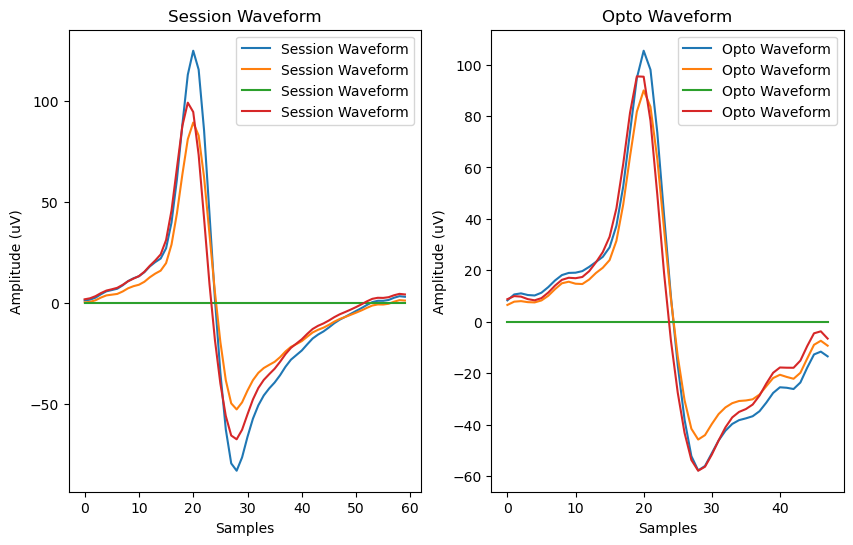

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(waveform_session_ref[(peak_sample-20):(peak_sample+40), :], label='Session Waveform')
axes[0].set_title('Session Waveform')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].legend()
axes[1].plot(waveform_opto[(peak_sample_opto-20):(peak_sample_opto+40), :], label='Opto Waveform')
axes[1].set_title('Opto Waveform')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude (uV)')
axes[1].legend()


In [14]:
ephys_data

,session,unit,Lratio,opto,delay,behavior,Idfile,subfolder,comments,depth,...,spikeProp,spikePropSham,baseline,width_opto,pulseWidth,spikeNum,optoWaveform,isiV,waveform,width_session
0,mZS061d20210405,TT1_SS_01,0.1100,1.0,300,1,TT1_SS_01,20ms,NaN,2.932,...,None,None,None,None,None,None,None,None,None,None
1,mZS061d20210405,TT4_SS_01,0.0230,1.0,300,1,TT4_SS_01,20ms,NaN,2.932,...,"[0.6, 0.3, 0.7, 0.5, 0.9, 0.5, 0.8, 0.5, 0.5, ...",0.07274892310991075,3.6374461554955375,5,20,"[[0, 0, 0, 0, 2, 0, 0, 0, 1, 0], [0, 1, 0, 3, ...","[[4.923154650559608, 3.1369245747925047, 0.0, ...",0,"[[26.141636919938808, 11.557623661397246, 17.7...",6
2,mZS061d20210405,TT4_SS_02,0.0310,1.0,300,1,TT4_SS_02,20ms,NaN,2.932,...,"[0.1, 0.4, 0.5, 0.7, 0.6, 0.3, 0.4, 0.6, 0.5, ...",0.06152826584320324,3.0764132921601623,8,20,"[[2, 0, 2, 3, 0, 0, 0, 2, 0, 0], [0, 0, 1, 1, ...","[[2.205837978405899, 2.746839201852177, 0.0, 4...",0.0008005489478499542,"[[33.755668086085855, 29.798250661756242, 21.2...",9
3,mZS061d20210405,TT5_SS_01,0.0086,1.0,300,1,TT5_SS_01,20ms,NaN,2.932,...,"[1.0, 1.0, 0.8, 0.8, 0.5, 0.8, 0.7, 0.7, 0.5, ...",0.046356569776084565,2.317828488804228,9,20,"[[2, 1, 1, 2, 0, 1, 0, 0, 1, 0], [1, 1, 0, 1, ...","[[-0.3393486681754875, 0.0, -1.713489755614554...",0.000351493848857645,"[[24.616136484805402, 15.789230495823707, 31.4...",12


In [9]:
# load back
out_path = os.path.join(parse_session_string(session)['sortedFolder'], f"{session}_nwb.zarr")
with NWBZarrIO(out_path, mode='r') as io:
    nwbfile_loaded = io.read()
print(nwbfile_loaded.trials.to_dataframe())
nwbfile_loaded.acquisition['left_lick_time'].timestamps[:10], nwbfile_loaded.acquisition['right_lick_time'].timestamps[:10]  # first 10 timestamps
nwbfile_loaded.acquisition.keys()  # all acquisition keys

     start_time  stop_time trial_type  animal_response  rewarded_historyL  \
id                                                                          
0       109.359    116.692     CSplus                1              False   
1       116.692    121.893     CSplus                1              False   
2       121.893    134.316     CSplus                0              False   
3       134.316    139.407     CSplus                0              False   
4       139.407    146.319     CSplus                0              False   
..          ...        ...        ...              ...                ...   
588    4177.658   4184.343     CSplus                0              False   
589    4184.343   4188.634     CSplus                0              False   
590    4188.634   4193.350     CSplus                1              False   
591    4193.350   4197.599     CSplus                1              False   
592    4197.599        NaN     CSplus                1              False   

dict_keys(['FIP_rising_time', 'FIP_rising_time_raw', 'G-Iso_0', 'G-Iso_1', 'G-Iso_2', 'G_0', 'G_0_bright', 'G_0_bright_mc', 'G_0_exp', 'G_0_exp_mc', 'G_0_tri-exp', 'G_0_tri-exp_mc', 'G_1', 'G_1_bright', 'G_1_bright_mc', 'G_1_exp', 'G_1_exp_mc', 'G_1_tri-exp', 'G_1_tri-exp_mc', 'G_2', 'G_2_bright', 'G_2_bright_mc', 'G_2_exp', 'G_2_exp_mc', 'G_2_tri-exp', 'G_2_tri-exp_mc', 'Iso_0', 'Iso_0_bright', 'Iso_0_bright_mc', 'Iso_0_exp', 'Iso_0_exp_mc', 'Iso_0_fit', 'Iso_0_tri-exp', 'Iso_0_tri-exp_mc', 'Iso_1', 'Iso_1_bright', 'Iso_1_bright_mc', 'Iso_1_exp', 'Iso_1_exp_mc', 'Iso_1_fit', 'Iso_1_tri-exp', 'Iso_1_tri-exp_mc', 'Iso_2', 'Iso_2_bright', 'Iso_2_bright_mc', 'Iso_2_exp', 'Iso_2_exp_mc', 'Iso_2_fit', 'Iso_2_tri-exp', 'Iso_2_tri-exp_mc', 'left_lick_time', 'right_lick_time'])